# Wind farm optimisation

In [1]:
import os

import cartopy.crs as ccrs
import contextily as cx
import geopandas as gpd
import mapclassify as mc
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import seaborn as sns
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter
from matplotlib import patheffects
from matplotlib_scalebar.scalebar import ScaleBar

from h2ss import capacity as cap
from h2ss import compare
from h2ss import data as rd
from h2ss import functions as fns
from h2ss import optimisation as opt

In [2]:
# basemap cache directory
cx.set_cache_dir(os.path.join("data", "basemaps"))

## Halite data

In [3]:
ds, extent = rd.kish_basin_data_depth_adjusted(
    dat_path=os.path.join("data", "kish-basin"),
    bathymetry_path=os.path.join("data", "bathymetry"),
)

## Constraints

In [4]:
# exploration wells
_, wells_b = fns.constraint_exploration_well(
    data_path=os.path.join(
        "data",
        "exploration-wells",
        "Exploration_Wells_Irish_Offshore.shapezip.zip",
    )
)

# wind farms
wind_farms = fns.constraint_wind_farm(
    data_path=os.path.join(
        "data", "wind-farms", "marine-area-consent-wind.zip"
    )
)

# frequent shipping routes
_, shipping_b = fns.constraint_shipping_routes(
    data_path=os.path.join(
        "data", "shipping", "shipping_frequently_used_routes.zip"
    ),
    dat_extent=extent,
)

# shipwrecks
_, shipwrecks_b = fns.constraint_shipwrecks(
    data_path=os.path.join(
        "data", "shipwrecks", "IE_GSI_MI_Shipwrecks_IE_Waters_WGS84_LAT.zip"
    ),
    dat_extent=extent,
)

# subsea cables
_, cables_b = fns.constraint_subsea_cables(
    data_path=os.path.join("data", "subsea-cables", "KIS-ORCA.gpkg")
)

In [5]:
# distance from salt formation edge
edge_buffer = fns.constraint_halite_edge(dat_xr=ds)

## Zones of interest

In [6]:
zones, zds = fns.zones_of_interest(
    dat_xr=ds,
    constraints={"net_height": 120, "min_depth": 500, "max_depth": 2000},
)

## Generate caverns

In [7]:
caverns = fns.generate_caverns_hexagonal_grid(
    zones_df=zones,
    dat_extent=extent,
)

In [8]:
caverns = fns.cavern_dataframe(
    dat_zone=zds,
    cavern_df=caverns,
    depths={"min": 500, "min_opt": 1000, "max_opt": 1500, "max": 2000},
)

In [9]:
# label caverns by depth and heights
caverns = fns.label_caverns(
    cavern_df=caverns,
    heights=[120],
    depths={"min": 500, "min_opt": 1000, "max_opt": 1500, "max": 2000},
)

In [10]:
caverns, _ = fns.generate_caverns_with_constraints(
    cavern_df=caverns,
    exclusions={
        "wells": wells_b,
        "wind_farms": wind_farms,
        "shipwrecks": shipwrecks_b,
        "shipping": shipping_b,
        "cables": cables_b,
        "edge": edge_buffer,
    },
)

Without constraints...
Number of potential caverns: 568
------------------------------------------------------------
Excluding salt formation edges...


Number of potential caverns: 539
------------------------------------------------------------
Exclude shipping...
Number of potential caverns: 261
Caverns excluded: 51.58%
------------------------------------------------------------
Exclude wind farms...
Number of potential caverns: 218
Caverns excluded: 59.55%
------------------------------------------------------------
Exclude cables...
Number of potential caverns: 218
Caverns excluded: 59.55%
------------------------------------------------------------
Exclude wells...
Number of potential caverns: 218
Caverns excluded: 59.55%
------------------------------------------------------------
Exclude shipwrecks...
Number of potential caverns: 218
Caverns excluded: 59.55%
------------------------------------------------------------


## Capacity

In [11]:
print(
    "Assumed density of hydrogen in the pipelines: "
    f"{cap.HYDROGEN_DENSITY} kg m\N{SUPERSCRIPT MINUS}\N{SUPERSCRIPT THREE}"
)

Assumed density of hydrogen in the pipelines: 8 kg m⁻³


In [12]:
caverns["cavern_total_volume"] = cap.cavern_volume(
    height=caverns["cavern_height"]
)
caverns["cavern_volume"] = cap.corrected_cavern_volume(
    v_cavern=caverns["cavern_total_volume"]
)

caverns["t_mid_point"] = cap.temperature_cavern_mid_point(
    height=caverns["cavern_height"], depth_top=caverns["cavern_depth"]
)

(
    caverns["p_operating_min"],
    caverns["p_operating_max"],
) = cap.pressure_operating(
    thickness_overburden=caverns["TopDepthSeabed"],
    depth_water=-caverns["Bathymetry"],
)

caverns["rho_min"], caverns["rho_max"] = cap.density_hydrogen_gas(
    p_operating_min=caverns["p_operating_min"],
    p_operating_max=caverns["p_operating_max"],
    t_mid_point=caverns["t_mid_point"],
)

(
    caverns["working_mass"],
    caverns["mass_operating_min"],
    caverns["mass_operating_max"],
) = cap.mass_hydrogen_working(
    rho_h2_min=caverns["rho_min"],
    rho_h2_max=caverns["rho_max"],
    v_cavern=caverns["cavern_volume"],
)

caverns["capacity"] = cap.energy_storage_capacity(
    m_working=caverns["working_mass"]
)

## Power curve [MW] and Weibull wind speed distribution

In [13]:
# extract data for wind farms at 150 m
weibull_wf_df = fns.read_weibull_data(
    data_path_weibull=os.path.join(
        "data", "weibull-parameters-wind-speeds", "Weibull_150m_params_ITM.zip"
    ),
    data_path_wind_farms=os.path.join(
        "data", "wind-farms", "marine-area-consent-wind.zip"
    ),
)

In [14]:
weibull_powercurve = opt.weibull_distribution(weibull_wf_data=weibull_wf_df)

In [15]:
weibull_powercurve.head()

,wind_speed,power_curve,Codling Wind Park,Dublin Array,North Irish Sea Array
0,0.00,0.0,0.000000,0.000000,0.000000
1,0.01,0.0,0.000250,0.000260,0.000070
2,0.02,0.0,0.000484,0.000503,0.000154
3,0.03,0.0,0.000711,0.000739,0.000243
4,0.04,0.0,0.000935,0.000972,0.000337


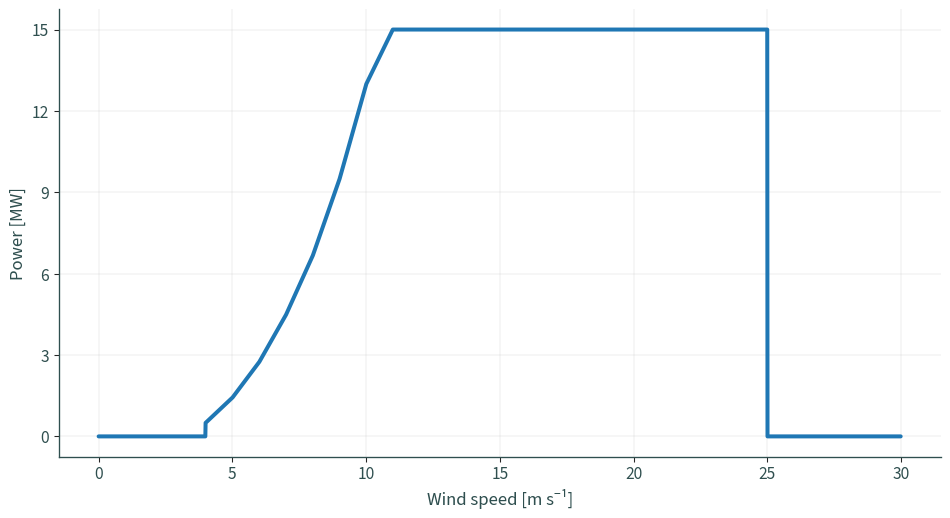

In [16]:
ax = weibull_powercurve.plot(
    x="wind_speed",
    y="power_curve",
    linewidth=3,
    color="tab:blue",
    figsize=(10, 5.5),
    legend=False,
)
ax.set_xlabel("Wind speed [m s\N{SUPERSCRIPT MINUS}\N{SUPERSCRIPT ONE}]")
ax.set_ylabel("Power [MW]")
plt.yticks([3 * n for n in range(6)])
sns.despine()
ax.xaxis.grid(True, linewidth=0.25)
ax.yaxis.grid(True, linewidth=0.25)
plt.tight_layout()
# plt.savefig(
#     os.path.join("graphics", "fig_powercurve.jpg"), format="jpg", dpi=600
# )
plt.show()

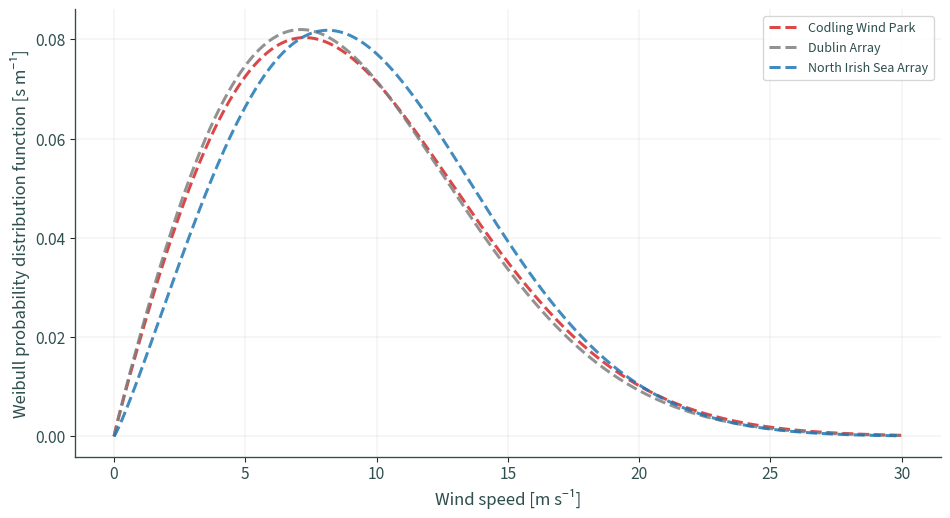

In [17]:
plt.figure(figsize=(10, 5.5))
ax = sns.lineplot(
    data=weibull_powercurve.drop(columns=["power_curve"]).melt(
        id_vars="wind_speed"
    ),
    x="wind_speed",
    y="value",
    hue="variable",
    linestyle="dashed",
    linewidth=2.25,
    alpha=0.85,
    palette=sns.color_palette(["tab:red", "tab:gray", "tab:blue"]),
)
ax.set_xlabel("Wind speed [m s\N{SUPERSCRIPT MINUS}\N{SUPERSCRIPT ONE}]")
ax.set_ylabel(
    "Weibull probability distribution function "
    "[s m\N{SUPERSCRIPT MINUS}\N{SUPERSCRIPT ONE}]"
)
ax.xaxis.grid(True, linewidth=0.25)
ax.yaxis.grid(True, linewidth=0.25)
sns.despine()
ax.legend(title=None, fontsize=10.5)
plt.tight_layout()
# plt.savefig(
#     os.path.join("graphics", "fig_weibull.jpg"), format="jpg", dpi=600
# )
plt.show()

## Number of reference wind turbines

In [18]:
# number of 15 MW turbines, rounded down to the nearest integer
weibull_wf_df["n_turbines"] = opt.number_of_turbines(
    owf_cap=weibull_wf_df["cap"]
)

## Annual energy production [MWh]

In [19]:
weibull_wf_df = opt.annual_energy_production(weibull_wf_data=weibull_wf_df)

## Annual hydrogen production [kg]

In [20]:
weibull_wf_df["AHP"] = opt.annual_hydrogen_production(aep=weibull_wf_df["AEP"])

## AHP as a proportion of the total working mass

In [21]:
weibull_wf_df["AHP_frac"] = (
    weibull_wf_df["AHP"] / caverns[["working_mass"]].sum().iloc[0]
)

## AHP converted to storage demand [GWh]

In [22]:
weibull_wf_df["demand"] = cap.energy_storage_capacity(
    m_working=weibull_wf_df["AHP"]
)

## Number of caverns required based on cumulative working mass and AHP

In [23]:
compare.calculate_number_of_caverns(
    cavern_df=caverns, weibull_wf_data=weibull_wf_df
)

Codling Wind Park
Working mass [kg]: 9.939208E+07
Number of caverns required: 22–47
Capacity (approx.) [GWh]: 3,387.58
------------------------------------------------------------------------------
Dublin Array
Working mass [kg]: 6.115752E+07
Number of caverns required: 14–31
Capacity (approx.) [GWh]: 2,140.49
------------------------------------------------------------------------------
North Irish Sea Array
Working mass [kg]: 4.097904E+07
Number of caverns required: 9–22
Capacity (approx.) [GWh]: 1,409.11
------------------------------------------------------------------------------
Total number of caverns required: 45–100
------------------------------------------------------------------------------
Number of caverns required as a percentage of all available caverns:
20.64–45.87%
------------------------------------------------------------------------------
Total maximum cavern capacity (approx.): 6,937.17 GWh


## Transmission distance [km]

In [24]:
caverns, injection_point = opt.transmission_distance(
    cavern_df=caverns, wf_data=wind_farms
)

## Electrolyser capacity [MW]

In [25]:
weibull_wf_df["E_cap"] = opt.electrolyser_capacity(
    n_turbines=weibull_wf_df["n_turbines"]
)

## CAPEX for pipeline [€ km⁻¹]

In [26]:
weibull_wf_df["CAPEX"] = opt.capex_pipeline(e_cap=weibull_wf_df["E_cap"])

In [27]:
weibull_wf_df

,name,cap,"(c, min)","(c, max)","(c, mean)","(k, min)","(k, max)","(k, mean)",n_turbines,AEP,integral,abserr,AHP,AHP_frac,demand,E_cap,CAPEX
0,Codling Wind Park,1300,10.2,10.8,10.500000,1.9,2.0,1.950000,86,5.641837e+06,8.320999,4.586017e-07,9.939208e+07,0.139850,3311.965117,1079,1.462152e+06
1,Dublin Array,824,9.9,10.6,10.292857,1.9,2.0,1.950000,54,3.471511e+06,8.154141,4.675453e-07,6.115752e+07,0.086052,2037.904469,677,1.212022e+06
2,North Irish Sea Array,500,10.7,11.2,10.950000,2.1,2.2,2.133333,33,2.326111e+06,8.940667,2.983609e-07,4.097904e+07,0.057660,1365.512688,414,1.037363e+06


In [28]:
# totals
weibull_wf_df[
    ["cap", "n_turbines", "AEP", "AHP", "AHP_frac", "demand", "E_cap", "CAPEX"]
].sum()

cap           2.624000e+03
n_turbines    1.730000e+02
AEP           1.143946e+07
AHP           2.015286e+08
AHP_frac      2.835622e-01
demand        6.715382e+03
E_cap         2.170000e+03
CAPEX         3.711537e+06
dtype: float64

In [29]:
compare.electricity_demand_ie(data=weibull_wf_df["demand"])

Energy capacity as a percentage of Ireland's electricity demand
in 2050 (84–122 TWh electricity): 3.30–4.80%


In [30]:
compare.hydrogen_demand_ie(data=weibull_wf_df["demand"])

Energy capacity as a percentage of Ireland's domestic hydrogen
demand in 2050 (4.6–39 TWh hydrogen): 17.22–145.99%
Energy capacity as a percentage of Ireland's domestic and
non-domestic hydrogen demand in 2050 (19.8–74.6 TWh hydrogen): 9.00–33.92%


## LCOT for pipeline [€ kg⁻¹]

In [31]:
caverns = opt.lcot_pipeline(weibull_wf_data=weibull_wf_df, cavern_df=caverns)

In [32]:
caverns[
    [
        "cavern_depth",
        "working_mass",
        "capacity",
        "distance_ip",
    ]
    + list(caverns.filter(like="dist_"))
    + list(caverns.filter(like="LCOT_"))
].describe()

,cavern_depth,working_mass,capacity,distance_ip,dist_Codling_Wind_Park,dist_Dublin_Array,dist_North_Irish_Sea_Array,LCOT_Codling_Wind_Park,LCOT_Dublin_Array,LCOT_North_Irish_Sea_Array
count,218.000000,2.180000e+02,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000
mean,1154.020877,3.260108e+06,108.634041,29.197826,58.408245,43.581633,44.393167,0.070392,0.070858,0.092186
std,365.142804,7.786651e+05,25.946851,6.830597,11.452952,13.055932,7.523248,0.013745,0.021108,0.015537
min,502.745339,1.678950e+06,55.946359,16.263066,33.027322,17.542931,32.980512,0.039931,0.028759,0.068617
25%,872.651330,2.685380e+06,89.482842,23.216441,51.592318,33.503367,36.808911,0.062212,0.054564,0.076523
50%,1128.329146,3.277441e+06,109.211632,30.947028,58.988376,47.378240,44.619590,0.071088,0.076996,0.092654
75%,1433.385847,3.886101e+06,129.493525,34.863247,67.109072,54.107289,50.773606,0.080834,0.087875,0.105363
max,1980.680682,4.765555e+06,158.798899,42.990158,80.806729,70.176200,67.926218,0.097273,0.113855,0.140786


In [33]:
caverns[list(caverns.filter(like="LCOT_"))].describe().mean(axis=1)

count    218.000000
mean       0.077812
std        0.016797
min        0.045769
25%        0.064433
50%        0.080246
75%        0.091357
max        0.117305
dtype: float64

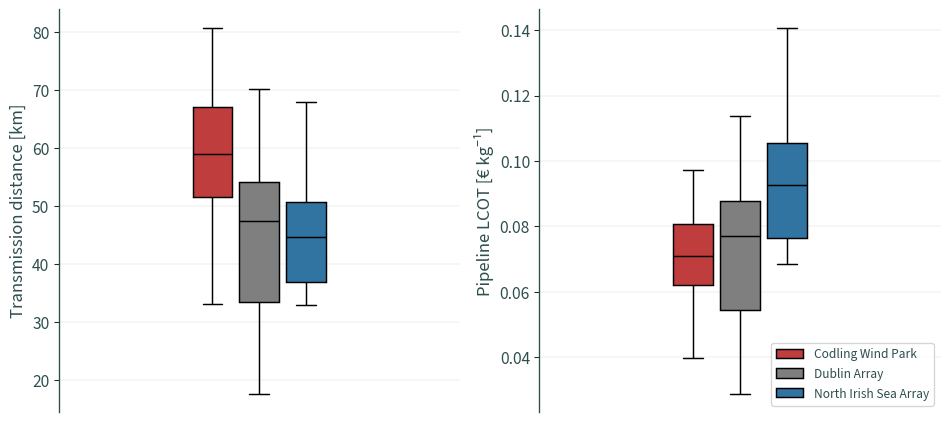

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4.5))
sns.boxplot(
    caverns.filter(like="dist_")
    .set_axis(list(wind_farms["name"]), axis=1)
    .melt(),
    y="value",
    hue="variable",
    palette=sns.color_palette(["tab:red", "tab:gray", "tab:blue"]),
    width=0.35,
    ax=axes[0],
    legend=False,
    linecolor="black",
    linewidth=1.1,
    gap=0.15,
)
axes[0].set_ylabel("Transmission distance [km]")
axes[0].tick_params(axis="x", bottom=False)
sns.boxplot(
    caverns.filter(like="LCOT_")
    .set_axis(list(wind_farms["name"]), axis=1)
    .melt(),
    y="value",
    hue="variable",
    palette=sns.color_palette(["tab:red", "tab:gray", "tab:blue"]),
    width=0.35,
    ax=axes[1],
    linecolor="black",
    linewidth=1.1,
    gap=0.15,
)
axes[1].set_ylabel("Pipeline LCOT [€ kg⁻¹]")
axes[1].legend(loc="lower right")
axes[1].tick_params(axis="x", bottom=False)
axes[1].yaxis.grid(True, linewidth=0.25)
axes[0].yaxis.grid(True, linewidth=0.25)
sns.despine(bottom=True)
plt.tight_layout()
# plt.savefig(
#     os.path.join("graphics", "fig_box_transmission_ntg.jpg"),
#     format="jpg",
#     dpi=600,
# )
plt.show()

## Maps

In [35]:
shape = rd.halite_shape(dat_xr=ds).buffer(1000).buffer(-1000)

In [36]:
def plot_map_facet(
    cavern_df,
    classes,
    fontsize=11.5,
):
    """Helper function for plotting LCOT facet maps"""
    fig1 = plt.figure(figsize=(11, 11.75))
    xmin_, ymin_, xmax_, ymax_ = cavern_df.total_bounds
    colours = [int(n * 255 / (len(classes) - 1)) for n in range(len(classes))]
    legend_handles = []
    classes = sorted(classes)

    for n1, c in enumerate(colours):
        if n1 == 0:
            label = f"< {classes[n1]:.2f}"
        elif n1 == len(colours) - 1:
            label = f"≥ {classes[-2]:.2f}"
        else:
            label = f"{classes[n1 - 1]:.2f}–{classes[n1]:.2f}"
        legend_handles.append(
            mpatches.Patch(
                facecolor=sns.color_palette("flare", 256)[c], label=label
            )
        )

    for a, wf1 in enumerate(list(wind_farms["name"])):
        ax1 = fig1.add_subplot(2, 2, a + 1, projection=ccrs.epsg(rd.CRS))
        gpd.GeoDataFrame(cavern_df, geometry=cavern_df.centroid).plot(
            ax=ax1,
            scheme="UserDefined",
            classification_kwds={"bins": classes},
            column=f"LCOT_{wf1.replace(' ', '_')}",
            zorder=2,
            marker=".",
            cmap="flare",
            markersize=20,
        )
        shape.plot(
            ax=ax1, color="white", alpha=0.5, edgecolor="slategrey", zorder=1
        )
        cx.add_basemap(
            ax1,
            crs=rd.CRS,
            source=cx.providers.CartoDB.VoyagerNoLabels,
            attribution=False,
        )
        ax1.gridlines(
            draw_labels={"bottom": "x"},
            color="lightslategrey",
            alpha=0.25,
            xlabel_style={"fontsize": fontsize},
            xformatter=LongitudeFormatter(auto_hide=False, dms=True),
        )
        if not a == 1:
            ax1.gridlines(
                draw_labels={"left": "y"},
                color="lightslategrey",
                alpha=0.25,
                ylabel_style={"fontsize": fontsize, "rotation": 90},
                yformatter=LatitudeFormatter(auto_hide=False, dms=True),
            )
        if a == 2:
            ax1.add_artist(
                ScaleBar(
                    1,
                    box_alpha=0,
                    location="lower right",
                    color="darkslategrey",
                    font_properties={"size": fontsize},
                )
            )
            plt.legend(
                loc="lower right",
                bbox_to_anchor=(1, 0.075),
                handles=legend_handles,
                title="Pipeline LCOT [€ kg⁻¹]",
                fontsize=fontsize,
                title_fontsize=fontsize,
            )
        plt.xlim(xmin_ - 1000, xmax_ + 1000)
        plt.ylim(ymin_ - 1000, ymax_ + 1000)
        ax1.set_title(list(wind_farms["name"])[a])

    plt.tight_layout()
    # plt.savefig(
    #     os.path.join("graphics", "fig_map_transmission_ntg.jpg"),
    #     format="jpg", dpi=600
    # )
    plt.show()

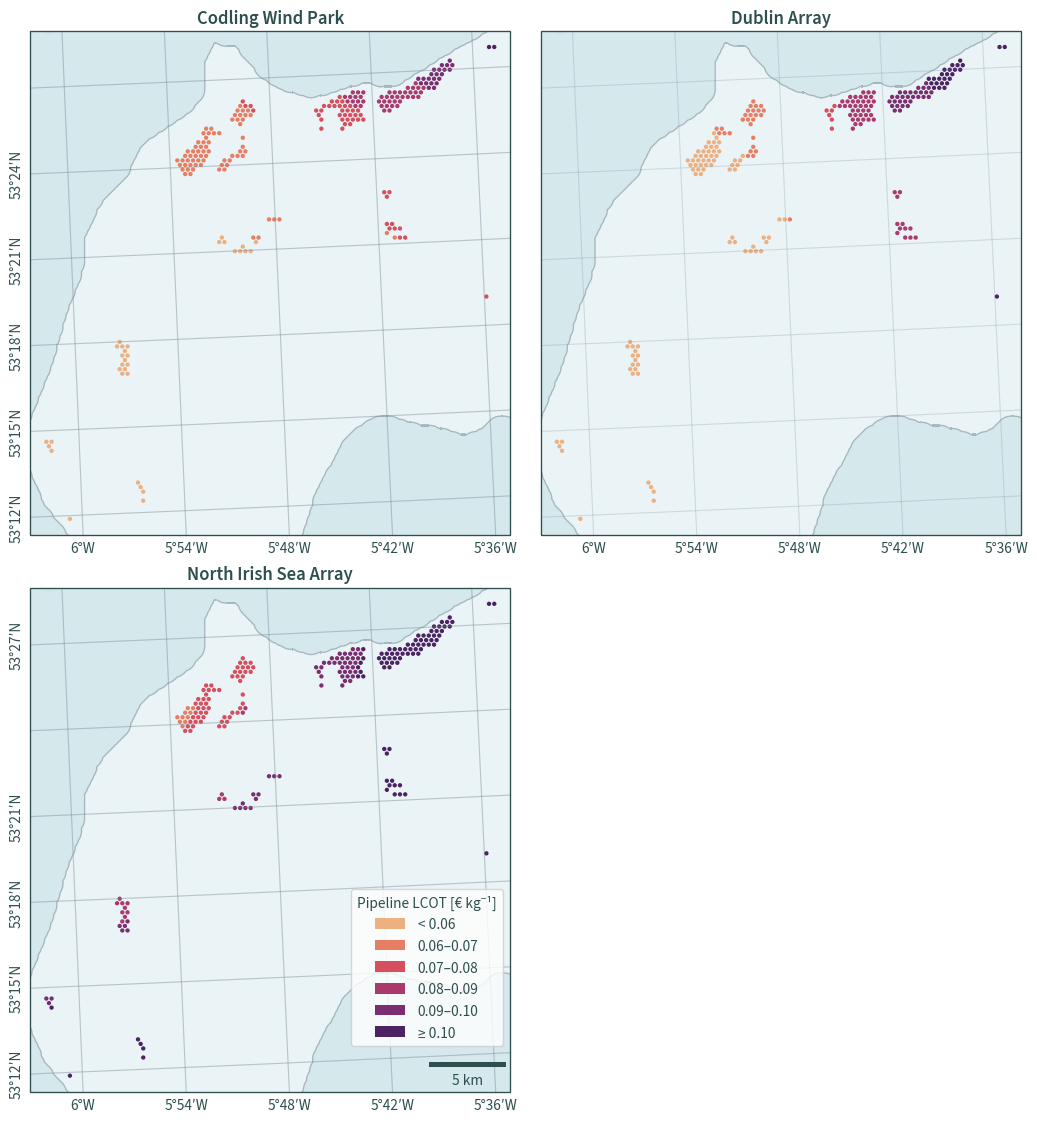

In [37]:
plot_map_facet(
    caverns,
    list(mc.Quantiles(caverns[list(caverns.filter(like="LCOT_"))], k=6).bins),
)

In [38]:
def plot_map_extent(cavern_df):
    """Helper function for plotting extent map"""
    xmin_, _, xmax_, _ = extent.total_bounds
    _, ymin_, _, ymax_ = wind_farms.total_bounds
    plt.figure(figsize=(6, 6))
    ax2 = plt.axes(projection=ccrs.epsg(rd.CRS))
    shape.plot(
        ax=ax2, color="white", alpha=0.5, edgecolor="slategrey", zorder=1
    )
    gpd.GeoDataFrame(cavern_df, geometry=cavern_df.centroid).plot(
        ax=ax2, marker=".", markersize=2.5, color="firebrick"
    )
    gpd.GeoDataFrame(cavern_df, geometry=cavern_df.centroid).dissolve().buffer(
        1000
    ).envelope.boundary.plot(ax=ax2, color="darkslategrey")
    wind_farms.plot(
        ax=ax2, facecolor="none", hatch="///", edgecolor="royalblue"
    )
    plt.xlim(xmin_ - 19000, xmax_ + 1500)
    plt.ylim(ymin_ - 3000, ymax_ + 3000)
    injection_point.plot(ax=ax2, marker="*", color="darkslategrey")
    basemap = cx.providers.CartoDB.VoyagerNoLabels
    cx.add_basemap(
        ax2,
        crs=rd.CRS,
        source=cx.providers.CartoDB.VoyagerNoLabels,
        attribution=False,
    )
    ax2.text(xmin_ - 18500, ymin_ - 2400, basemap["attribution"], fontsize=7.5)
    map_labels = zip(
        zip(wind_farms.centroid.x, wind_farms.centroid.y), wind_farms["name"]
    )
    for xy, lab in map_labels:
        ax2.annotate(
            text=lab,
            xy=xy,
            path_effects=[
                patheffects.withStroke(linewidth=2.5, foreground="white")
            ],
            fontsize=13,
            va="center",
            fontweight="semibold",
        )
    ax2.annotate(
        text="DUBLIN\nPORT",
        xy=(
            injection_point.centroid.x[0] - 1500,
            injection_point.centroid.y[0],
        ),
        path_effects=[patheffects.withStroke(linewidth=2, foreground="white")],
        fontsize=13,
        va="center",
        ha="right",
        font="Montserrat",
        fontweight="semibold",
    )
    ax2.add_artist(
        ScaleBar(
            1,
            box_alpha=0,
            location="lower right",
            color="darkslategrey",
            font_properties={"size": 11.5},
        )
    )
    plt.tight_layout()
    # plt.savefig(
    #     os.path.join("graphics", "fig_transmission_map_inset.jpg"),
    #     format="jpg",
    #     dpi=600,
    # )
    plt.show()

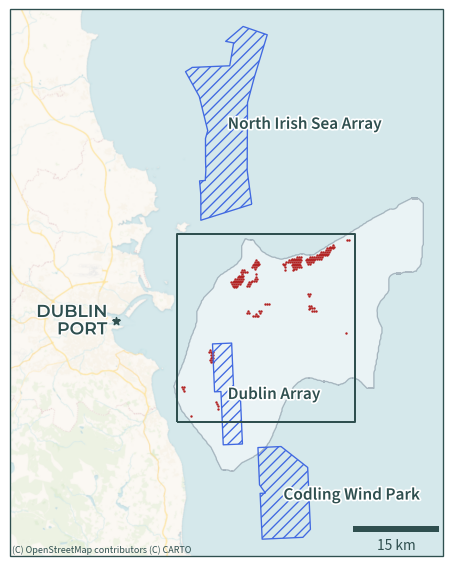

In [39]:
plot_map_extent(caverns)